In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

In [2]:
# Storing the recipes information into a pandas DataFrame titled 'recipes'
recipes = pd.read_csv('recipes.csv', engine='python', on_bad_lines='skip')

In [3]:
# Storing the reviews information into a pandas DataFrame titled 'reviews'
reviews = pd.read_csv('reviews.csv', engine='python', on_bad_lines='skip')

# ⚡ Data pre-processing

In [4]:
# Truncating the DateSubmitted and DateModified columns
reviews=reviews[['ReviewId','RecipeId','AuthorId','AuthorName','Rating','Review']]

In [5]:
# Function for counting Null values 
def countNullValues(col):
  c = 0
  for i in col:
    if(i != i):
      c+=1
  return c

In [6]:
# Counting null values in the reviews dataframe
c1 = countNullValues(reviews.ReviewId)
c2 = countNullValues(reviews.RecipeId) 
c3 = countNullValues(reviews.AuthorId)
c4 = countNullValues(reviews.AuthorName) 
c5 = countNullValues(reviews.Rating)
c6 = countNullValues(reviews.Review) 

In [7]:
# Function for replacing Null Values
def replaceNullValue(column):
  j = 0
  for i in column:
    if(str(i) == 'nan'):
      column[j] = 'NA'
    j+=1
  return column

In [8]:
replaceNullValue(reviews.Review)

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402076.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[j] = 'NA'
C:\Users\lim\AppData\Local\Temp\ipykernel_18468\3143402

0               better than any you can get at a restaurant!
1          I cut back on the mayo, and made up the differ...
2          i think i did something wrong because i could ...
3          easily the best i have ever had.  juicy flavor...
4                                         An excellent dish.
                                 ...                        
1401977    I was disappointed. I couldn't wait to make th...
1401978    Nothing to drain. And I don’t heat up the liqu...
1401979    Good base recipe for someone to start with. I ...
1401980    Thank you so much for this amazing recipe! I l...
1401981    I can't say enough about this recipe.... the b...
Name: Review, Length: 1401982, dtype: object

In [9]:
# Checking the column labels in reviews
reviews.columns, reviews.shape

(Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review'], dtype='object'),
 (1401982, 6))

In [10]:
# Printing a summary of the data in reviews data
# .describe() gives the statistics of the numerical data 
reviews.describe()

,ReviewId,RecipeId,AuthorId,Rating
count,1.401982e+06,1.401982e+06,1.401982e+06,1.401982e+06
mean,8.179739e+05,1.526412e+05,1.558638e+08,4.407951e+00
std,5.280821e+05,1.301112e+05,5.305111e+08,1.272012e+00
min,2.000000e+00,3.800000e+01,1.533000e+03,0.000000e+00
25%,3.743862e+05,4.703875e+04,1.336800e+05,4.000000e+00
50%,7.717805e+05,1.093270e+05,3.305450e+05,5.000000e+00
75%,1.204126e+06,2.318768e+05,8.183590e+05,5.000000e+00
max,2.090347e+06,5.412980e+05,2.002902e+09,5.000000e+00


C:\Users\lim\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


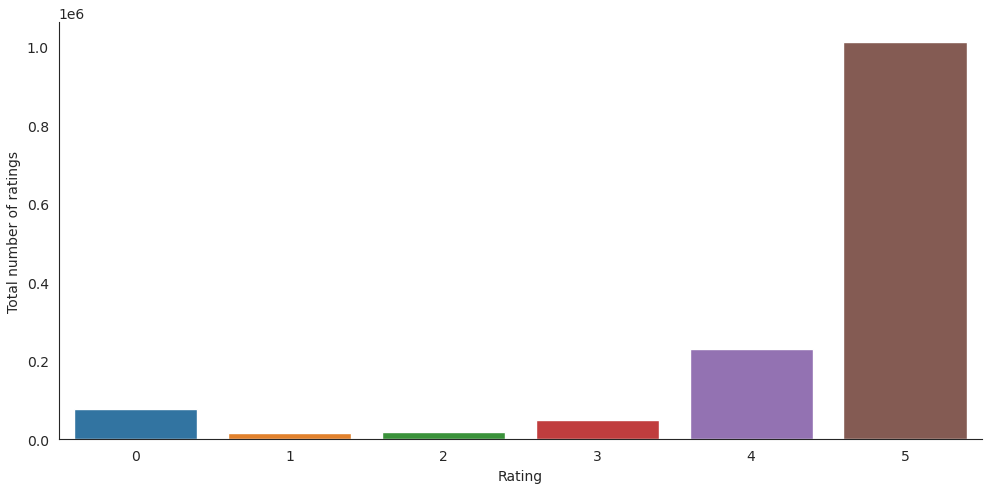

In [11]:
# Checking the Rating distribution in the range 0-5 for the Data given 
import seaborn as sns
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=reviews, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [12]:
print("\nTotal no of ratings :", reviews.shape[0])
print("Total No of authors   :", len(np.unique(reviews.AuthorId)))
print("Total No of recipes  :", len(np.unique(reviews.RecipeId)))


Total no of ratings : 1401982
Total No of authors   : 271907
Total No of recipes  : 271678


# ⚡ Item-based Collaborative based Recommender

In [13]:
# Setting rating count threshold
threshold = 51
counts = reviews['RecipeId'].value_counts()
valid_recipes = counts[counts >= threshold].index
valid_recipes

Index([ 45809,   2886,  27208,  89204,  39087,  67256,  35813,  54257,  22782,
        32204,
       ...
        61948,  65287, 100379,  29185,  14058, 116119, 147653, 124215,  93256,
       127262],
      dtype='int64', name='RecipeId', length=2791)

In [14]:
filtered_ratings = reviews[reviews['RecipeId'].isin(valid_recipes)]
filtered_ratings.shape

(344516, 6)

In [15]:
# Reset index value
filtered_ratings.reset_index(inplace = True, drop = True)
filtered_ratings.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review
0,19,13307,2046,Gay Gilmore ckpt,5,"chewy goodness, not crispy at all. i even thre..."
1,50,1078,2639,Elisabeth Summers,5,"Your recipe was wonderful, it all fit together..."
2,92,1600,2447,C.L. Miller,5,These make a wonderful healthy snack.
3,95,468,3125,Preeti De,3,It's a tasty dish.
4,102,5297,3228,Christine Fisher,4,This is a lovely little repice. Quite deliciou...


In [16]:
# Get user rating matrix
matrix = filtered_ratings.pivot(index = 'AuthorId', columns ='RecipeId', values = 'Rating').fillna(0)
matrix

RecipeId,56,76,220,246,319,468,481,536,607,632,...,495577,496614,497021,500210,501408,505862,508302,514605,515167,533997
AuthorId,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002901474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002901627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002901740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
with open('filtered_ratings.pkl', 'wb') as f:
    pickle.dump(filtered_ratings, f)

In [18]:
# testing input
users_rating = matrix[56]
users_rating.sort_values(ascending=False).head(20)

AuthorId
2000456678    5.0
712751        5.0
655596        5.0
1802700995    5.0
1056692       5.0
178738        5.0
265694        5.0
627002        5.0
363420        5.0
2731337       5.0
903305        5.0
2001262981    5.0
608544        5.0
47482         5.0
114027        5.0
229605        5.0
1802720493    5.0
47761         5.0
924744        5.0
165263        5.0
Name: 56, dtype: float64

In [19]:
similar_recipes = matrix.corrwith(users_rating)
similar_recipes

RecipeId
56        1.000000
76        0.011445
220       0.011078
246       0.010433
319      -0.000823
            ...   
505862   -0.000782
508302   -0.000690
514605   -0.000722
515167   -0.000909
533997   -0.000701
Length: 2791, dtype: float64

In [20]:
similar_recipes = pd.DataFrame(similar_recipes,columns=['correlation'])
similar_recipes.head(10)

,correlation
RecipeId,
56,1.000000
76,0.011445
220,0.011078
246,0.010433
319,-0.000823
468,-0.000837
481,-0.000926
536,-0.000828
607,0.014659


In [21]:
similar_recipes.sort_values(by='correlation', ascending=False).head(20)

,correlation
RecipeId,
56,1.000000
87421,0.077558
46461,0.058304
57830,0.053708
44906,0.053292
70646,0.053101
70239,0.051945
120835,0.051251
77854,0.050149


# Weighted Rating calculate

In [22]:
# Calculating the ratings given per recipe
RatingCounts = filtered_ratings.groupby('RecipeId')['Rating'].count()
RatingCounts.sort_values(ascending=False, inplace=True)
RatingCounts

RecipeId
45809     2892
2886      2182
27208     1614
89204     1584
39087     1491
          ... 
30579       51
141497      51
93256       51
179877      51
288125      51
Name: Rating, Length: 2791, dtype: int64

In [23]:
m = threshold

In [24]:
# Creating and merging smaller recipes dataframe with individual rating counts for a recipe
#recipesSubDataFrame = recipes.iloc[:9000]
weightedPopularRecipes = recipes.merge(RatingCounts, on='RecipeId')
weightedPopularRecipes

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,Rating
0,56,Buttermilk Pie,1581,thefensk,PT1H,PT20M,PT1H20M,1999-08-30T10:02:00Z,This recipe was originally noted by my wife on...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,101.5,269.8,52.2,0.7,39.9,5.0,8.0,NaN,"c(""Preheat oven to 400°F."", ""Beat the butter a...",168
1,76,Alfredo Sauce,1535,Marg CaymanDesigns,PT10M,PT5M,PT15M,1999-09-15T04:26:00Z,This is my son's favorite meal. I make it with...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,159.0,312.4,2.5,0.0,0.2,8.7,4.0,NaN,"c(""Place butter in microwave safe pot and heat...",200
2,220,Chocolate Zucchini Bread,1604,itsjustme,PT1H,PT25M,PT1H25M,1999-08-07T09:18:00Z,Make and share this Chocolate Zucchini Bread r...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,55.8,392.8,67.6,2.7,40.9,6.3,10.0,2 loaves,"c(""In a mixing bowl, beat eggs, oil, sugar and...",166
3,246,Lee's Hot Crab Dip,25843,Crab Place,PT30M,PT15M,PT45M,1999-09-01T13:37:00Z,Make and share this Lee's Hot Crab Dip recipe ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,55.5,397.3,3.0,0.0,1.8,8.2,8.0,NaN,"c(""Remove cartilage from crab meat."", ""In a la...",65
4,319,Fish Chowder,47510,Dreamgoddess,PT25M,PT30M,PT55M,1999-09-10T19:07:00Z,This is one of the recipes I adopted -- it's g...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,57.4,769.5,20.7,2.8,2.7,24.4,4.0,NaN,"c(""Cut cod fillets into bite sized pieces."", ""...",64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2786,505862,Loaded Baked Potato &amp; Chicken Casserole,256143,bsmith1,PT1H,PT30M,PT1H30M,2013-08-14T12:22:00Z,Make and share this Loaded Baked Potato &amp; ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,114.5,989.8,41.5,5.8,2.3,38.0,8.0,NaN,"c(""Preheat oven to 500 degrees."", ""In large bo...",66
2787,508302,Sugar Cookie in a Mug or Coffee Cup,1535,Marg CaymanDesigns,PT1M,PT4M,PT5M,2013-10-23T20:48:00Z,I was craving a cookie with my afternoon coffe...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,196.5,264.6,43.8,0.6,25.4,5.0,1.0,NaN,"c(""Spray microwave safe coffee mug with vegeta...",59
2788,514605,Animal-Style Skillet Potatoes #SP5,1802587715,Put On Your Cake Pa,PT30M,PT5M,PT35M,2014-03-19T23:50:00Z,Official Contest Entry: Simply Potatoes 5Fix. ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,12.2,283.9,6.5,0.6,4.3,2.6,4.0,NaN,"c(""First, start caramelizing the onions: heat ...",53
2789,515167,Simply Irresistible Tropical Potato Salad #SP5,1802633456,Roger B.,PT5M,PT8M,PT13M,2014-03-31T19:37:00Z,Official Contest Entry: Simply Potatoes 5Fix. ...,"""https://img.sndimg.com/food/image/upload/w_55...",...,45.7,1214.3,23.2,0.7,8.9,11.3,5.0,NaN,"c(""First microwave Simply Potatoes Traditional...",74


In [26]:
RatingAverages = recipes[recipes['AggregatedRating'].notnull()]['AggregatedRating'].astype('int')
C = RatingAverages.mean()
C

4.559496312580302

In [29]:
# Columns selected to appear in shortlisted dataframe are RecipeId, Name, RecipeCategory, AggregatedRating, Rating, and ReviewCount
qualifiedRecipes = weightedPopularRecipes[(weightedPopularRecipes['Rating'] >= threshold) & (weightedPopularRecipes['Rating'].notnull()) & (weightedPopularRecipes['AggregatedRating'].notnull())][['RecipeId', 'Name', 'RecipeCategory', 'AggregatedRating', 'Rating', 'ReviewCount']]

# Setting the datatype of 'Rating' and 'AggregatedRating' to int
qualifiedRecipes['Rating'] = qualifiedRecipes['Rating'].astype('int')
qualifiedRecipes['AggregatedRating'] = qualifiedRecipes['AggregatedRating'].astype('int') 

In [30]:
# Function that defines the mathematical formula for the weighted rating method
def weightedRating(x):
    v = x['Rating']
    R = x['AggregatedRating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [31]:
# Applying the WR function
qualifiedRecipes['score'] = qualifiedRecipes.apply(weightedRating, axis=1)
#qualifiedRecipes.loc[qualifiedRecipes["RecipeId"] == 56]
qualifiedRecipes.head()
names = qualifiedRecipes[["RecipeId","Name"]]
names

,RecipeId,Name
0,56,Buttermilk Pie
1,76,Alfredo Sauce
2,220,Chocolate Zucchini Bread
3,246,Lee's Hot Crab Dip
4,319,Fish Chowder
...,...,...
2786,505862,Loaded Baked Potato &amp; Chicken Casserole
2787,508302,Sugar Cookie in a Mug or Coffee Cup
2788,514605,Animal-Style Skillet Potatoes #SP5
2789,515167,Simply Irresistible Tropical Potato Salad #SP5


In [34]:
# Convert into same dataframe format 
df_rating = pd.DataFrame(qualifiedRecipes.groupby(by = ['RecipeId'])['score'].agg('mean')) 
df_rating.head(10)

,score
RecipeId,
56,4.897417
76,4.910495
220,4.896471
246,4.806330
319,4.804646
468,4.807986
481,4.831085
536,4.243883
607,4.888784


In [35]:
with open('dfRatingCollaborative.pkl', 'wb') as f:
    pickle.dump(df_rating, f)

In [36]:
result_recipes = similar_recipes.join(df_rating['score'] ).sort_values(by='correlation', ascending=False)
result_recipes = result_recipes[result_recipes['score'] > 4].sort_values(by = 'correlation', ascending = False)
result_recipes

,correlation,score
RecipeId,,
56,1.000000,4.897417
87421,0.077558,4.786041
46461,0.058304,4.855060
57830,0.053708,4.806330
44906,0.053292,4.781887
...,...,...
44232,-0.001488,4.911552
264191,-0.001511,4.921173
252449,-0.001554,4.931298


In [ ]:
#reset = result_recipes.reset_index()
#reset

In [39]:
def getCollaborativeRecommendations(id):
    
    if id in matrix.columns:
        # take the column of data for the recipe
        users_rating = matrix[id]
        # find correlation with the recipe
        similar_recipes = matrix.corrwith(users_rating, method='pearson')
        # convert into data frame
        similar_recipes = pd.DataFrame(similar_recipes,columns=['correlation'])
        # join the correlation with weighted rating score atleast higher than 4
        result_recipes = similar_recipes.join(df_rating['score']).sort_values(by='correlation', ascending=False)
        result_recipes = result_recipes[result_recipes['score'] > 4].sort_values(by = 'correlation', ascending = False)
        
        # selecting the top 10
        recipeIndices = result_recipes.iloc[1:11].index.tolist()
        # return top 10 recipes
        return names[names['RecipeId'].isin(recipeIndices)]
    
    else:
        return -1
        

In [40]:
getCollaborativeRecommendations(56)

,RecipeId,Name
1141,44906,Mom's Famous Crock Pot Cream Corn
1165,46461,Ro-tel Chicken Spaghetti
1402,57830,Best Beef Barley Soup
1597,70239,Cracker Barrel's Hash Browns Casserole - Copycat
1599,70646,Pineapple Upside Down Cake
1609,71472,Benihana Japanese Fried Rice
1699,77854,Kittencal's Best Deviled Eggs
1834,87421,Hush Puppies Justin Wilson Style
2242,120835,Kittencal's Easy Creamy White Glaze
2526,181195,Cilantro Chicken


In [ ]:
#names.loc[names['RecipeId']==recipeIndices]

In [ ]:
#index = [87421,101568,229104,89030]
#test = names[names['RecipeId'].isin(index)]
#test